# Exemple sur le modèle jouet Campbell

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
%reload_ext autoreload
%autoreload 2

import methods

c:\Users\sliss\anaconda3\envs\PIR\lib\site-packages\gpflow\versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
def Simulateur(x,z1,z2):
  return x[0]*np.exp(-(0.8*z1+0.2*z2-10*x[1])**2/(60*x[0]**2))+(x[1]+x[3])*np.exp((0.5*z1+0.5*z2)*x[0]/500)+x[4]*(x[2]-2)*np.exp(-(0.4*z1+0.6*z2-20*x[5])**2/(40*x[4]**2))+(x[5]+x[7])*np.exp((0.3*z1+0.7*z2)*x[6]/250)

#x=np.array([-1,-1,-1,-1,-1,-1,-1,-1])
#x=np.array([5,5,5,5,5,5,5,5])
x=np.array([5,3,1,-1,5,3,1,-1])

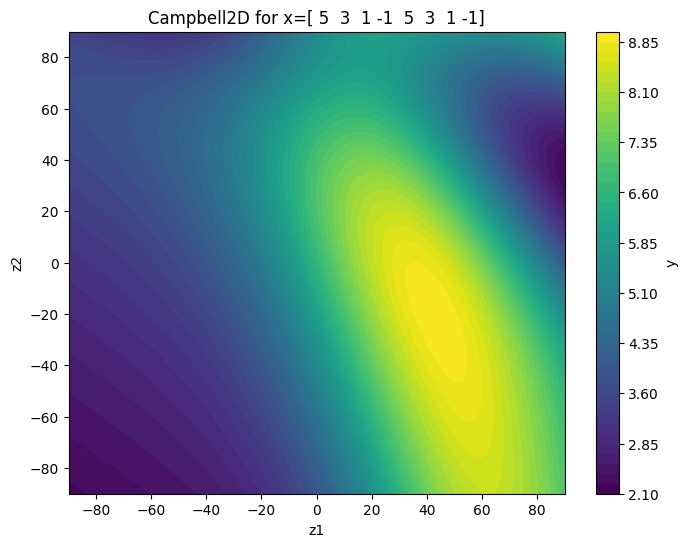

In [4]:
n_grid = 64
D = n_grid**2
z1_vals=np.linspace(-90,90,n_grid)
z2_vals=np.linspace(-90,90,n_grid)

Z1,Z2=np.meshgrid(z1_vals,z2_vals)

Y = Simulateur(x, Z1, Z2)
plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, Y, levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Campbell2D for x={x}')
plt.show()

In [ ]:
n_train = 200
n_dim = 8
bounds = np.array([-np.ones(n_dim),5*np.ones(n_dim)])
x_train = methods.lhs_optimized(n_train, n_dim ,bounds, n_iter=500, seed=42)#on simule les données d'entrée avec un hypercube latin optimisé
y_train = np.zeros((n_train,n_grid*n_grid))  # matrice (200, 4096)
for i in range(n_train):
    ytrain_i = Simulateur(x_train[i], Z1, Z2)
    y_train[i,:] = ytrain_i.flatten()
print("Forme de y_train :",y_train.shape)

n_test = 1000
x_test=np.random.uniform(-1,5,(n_test,8))
y_test = np.zeros((n_test,n_grid*n_grid))
for i in range(n_test):
    ytest_i = Simulateur(x_test[i], Z1, Z2)
    y_test[i,:] = ytest_i.flatten()
print("Forme de y_test :",y_test.shape)

Forme de y_train : (200, 4096)
Forme de y_test : (1000, 4096)


In [ ]:
# Affichage des points d'entrainements choisis


On va ajouter du bruit à nos données d'entrées pour s'assurer de la robustesse de nos méthodes.

In [ ]:
eps = 1e-3
x_train += eps*np.random.normal(size=x_train.shape)
x_test += eps*np.random.normal(size=x_test.shape)

Les fonctions suivantes se trouvent dans le fichier *methods.py*

## Méthode par ACP

In [6]:
n_pc = 5 #nombre composantes principales
theta = 3
sigma = 1
Y_test_reconstruct_ACP = methods.ACP(x_train,x_test,y_train,n_pc,[theta,sigma]) 

(200, 5)
Variance expliquée par les 5 premières composantes : [0.77542983 0.13512075 0.03266067 0.0195173  0.01679901]
Variance globale expliquée : 0.9795275725785997
Taille du jeu d'entrainement transformé par ACP : (200, 5)
Affichage des hyperparamètres optimisés

--- Composante principale 1 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [16.28657]             │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.

## Méthode par B-Splines

In [7]:
t1 = np.concatenate((
    np.repeat(-90, 2),
    np.arange(-80, 91, 10),
    np.repeat( 90, 2)
))
print("vecteur de noeuds",t1)
Y_test_reconstruct_Bsplines = methods.Bsplines_ACP(x_train, x_test, y_train,t1, t1, n_pc, [theta,sigma], degree=1)

vecteur de noeuds [-90 -90 -80 -70 -60 -50 -40 -30 -20 -10   0  10  20  30  40  50  60  70
  80  90  90  90]
taille du vecteur de y_train: (200, 4096)
taille de la base B-spline : 400
(200, 5)
Variance expliquée par les 5 premières composantes : [0.77399615 0.13928855 0.03053799 0.01860059 0.01634105]
Variance globale expliquée : 0.9787643261966475
Taille du jeu d'entrainement transformé par ACP : (200, 5)
Affichage des hyperparamètres optimisés

--- Composante principale 1 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │

## Méthode par Ondelettes

In [23]:
n_pc = 5 #nombre composantes principales
K_tilde = 1200
#Il faut mettre un p quasiment égal à 1 pour obtenir un résultat satisfaisant
p = 0.99999
Y_test_reconstruct_wavelet = methods.ACPF_Ondelettes(x_train,x_test,y_train,n_pc,[theta,sigma],K_tilde=0,p=p,J=3)

Nombre de coefficients conservés pour l'ACP : 1614
(200, 5)
Variance expliquée par les 5 premières composantes : [0.775443   0.13512183 0.03266043 0.01951721 0.01679912]
Variance globale expliquée : 0.9795415923026587
Taille du jeu d'entrainement transformé par ACP : (200, 5)
Affichage des hyperparamètres optimisés

--- Composante principale 1 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [151.11864]           │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────

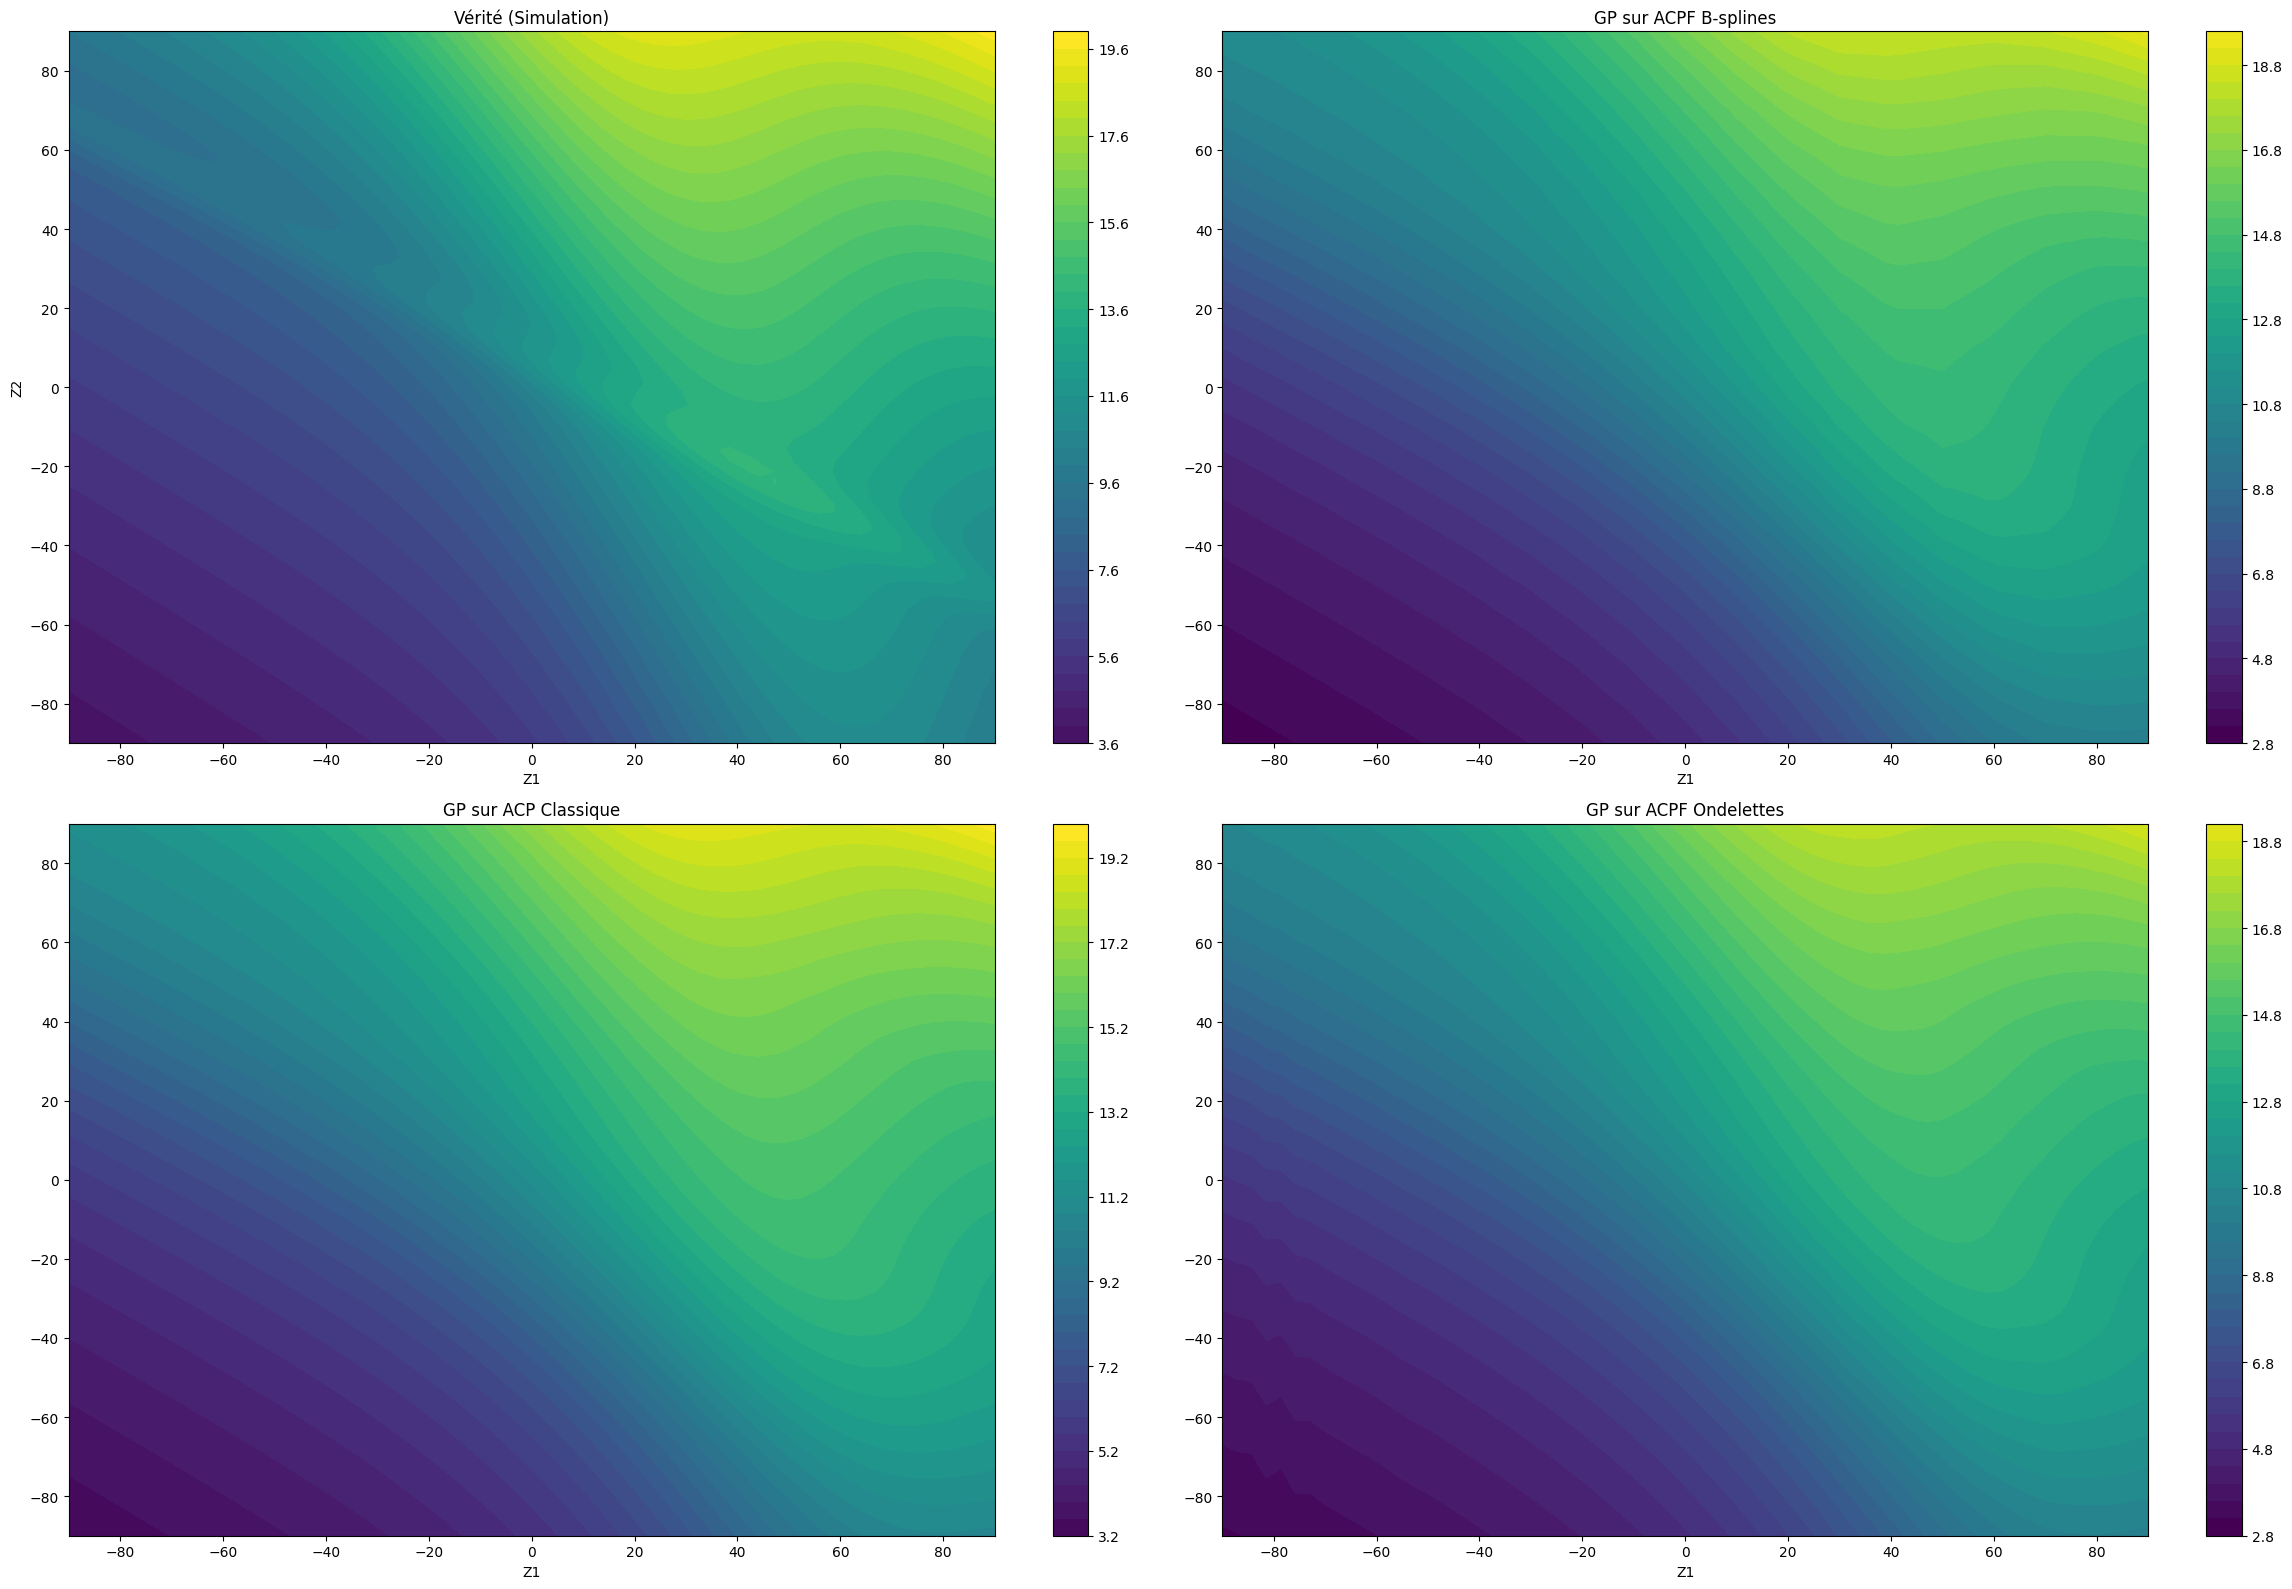

In [13]:
k = 7 #On choisit ici un indice arbitraire pour visualiser une sortie (on peut le changer comme on le souhaite)

# --- Reshape des champs
Y_true = np.reshape(y_test[k, :], (n_grid, n_grid))
Y_bs   = np.reshape(Y_test_reconstruct_Bsplines[k, :], (n_grid, n_grid))
Y_pca  = np.reshape(Y_test_reconstruct_ACP[k, :], (n_grid, n_grid))
Y_wave = np.reshape(Y_test_reconstruct_wavelet[k, :], (n_grid, n_grid))

# --- Trouver les min/max communs pour la même échelle colorimétrique
vmin = min(Y_true.min(), Y_bs.min(), Y_pca.min(),Y_wave.min())
vmax = max(Y_true.max(), Y_bs.max(), Y_pca.max(),Y_wave.max())

# --- Plot côte à côte
plt.figure(figsize=(24, 16))

# Vérité
plt.subplot(2, 2, 1)
contour1 = plt.contourf(Z1, Z2, Y_true, levels=50, vmin=vmin, vmax=vmax)
plt.colorbar(contour1)
plt.title("Vérité (Simulation)")
plt.xlabel("Z1")
plt.ylabel("Z2")

# Reconstruction B-splines+ACP + GP
plt.subplot(2, 2, 2)
contour2 = plt.contourf(Z1, Z2, Y_bs, levels=50, vmin=vmin, vmax=vmax)
plt.colorbar(contour2)
plt.title("GP sur ACPF B-splines")
plt.xlabel("Z1")

# Reconstruction ACP + GP
plt.subplot(2, 2, 3)
contour3 = plt.contourf(Z1, Z2, Y_pca, levels=50, vmin=vmin, vmax=vmax)
plt.colorbar(contour3)
plt.title("GP sur ACP Classique")
plt.xlabel("Z1")

# Reconstruction Ondelettes + ACP + GP
plt.subplot(2, 2, 4)
contour4 = plt.contourf(Z1, Z2, Y_wave, levels=50, vmin=vmin, vmax=vmax)
plt.colorbar(contour4)
plt.title("GP sur ACPF Ondelettes")
plt.xlabel("Z1")

plt.tight_layout()
plt.show()


# RMSE

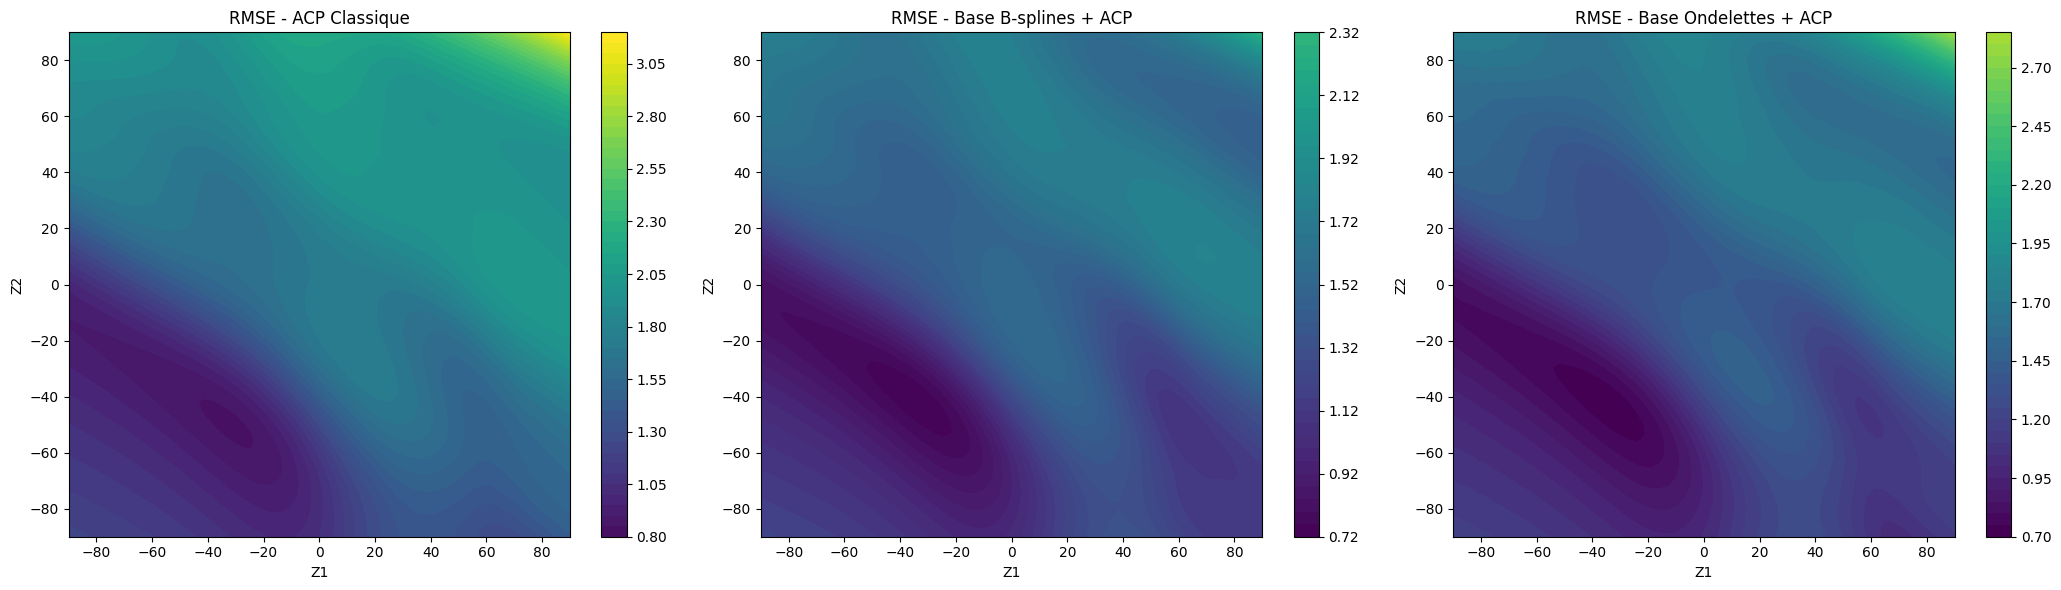

In [24]:
# --- Calcul RMSE pixel-par-pixel (ACP classique)
rmse_ACP = np.sqrt(np.mean((y_test - Y_test_reconstruct_ACP)**2, axis=0))
RMSE_map_ACP = rmse_ACP.reshape((n_grid, n_grid))

# --- Calcul RMSE pixel-par-pixel (B-splines)
rmse_BS = np.sqrt(np.mean((y_test - Y_test_reconstruct_Bsplines)**2, axis=0))
RMSE_map_BS = rmse_BS.reshape((n_grid, n_grid))

# --- Calcul RMSE pixel-par-pixel (Ondelettes)
rmse_wavelet = np.sqrt(np.mean((y_test - Y_test_reconstruct_wavelet)**2, axis=0))
RMSE_map_wavelet = rmse_wavelet.reshape((n_grid, n_grid))

# --- Trouver les min/max communs pour la même échelle colorimétrique
vmin = min(RMSE_map_ACP.min(), RMSE_map_BS.min(), RMSE_map_wavelet.min())
vmax = max(RMSE_map_ACP.max(), RMSE_map_BS.max(), RMSE_map_wavelet.max())

# --- Plot côte à côte
plt.figure(figsize=(21, 6))

# ACP classique
plt.subplot(1, 3, 1)
contour1 = plt.contourf(Z1, Z2, RMSE_map_ACP, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour1)
plt.title("RMSE - ACP Classique")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + B-splines
plt.subplot(1, 3, 2)
contour2 = plt.contourf(Z1, Z2, RMSE_map_BS, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour2)
plt.title("RMSE - Base B-splines + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + Ondelettes
plt.subplot(1, 3, 3)
contour3 = plt.contourf(Z1, Z2, RMSE_map_wavelet, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour3)
plt.title("RMSE - Base Ondelettes + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

plt.tight_layout()
plt.show()